In [1]:
! pip install numpy pandas sklearn matplotlib seaborn xgboost

In [2]:
# This notebook was run in a Python 3.8.10 environment
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# import some data and load into pandas df for easier viewing
# target: 0 = 'setosa' , 1 = 'versicolor' , 2 = 'virginica' 
iris_raw = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris_raw['data'], iris_raw['target']],
                     columns= iris_raw['feature_names'] + ['target'])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [4]:
# drop duplpicates and check how many of each species to see if dataset is balanced
df.drop_duplicates()
df["target"].value_counts()

0.0    50
1.0    50
2.0    50
Name: target, dtype: int64

<Figure size 1008x576 with 0 Axes>

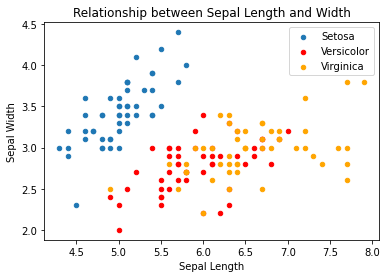

In [5]:
# ---VISUALISE DATA---
# scatter plot of sepal length and width data coloured by species
plt.figure(figsize=(14,8))
ax = df[df.target==0].plot.scatter(x='sepal length (cm)', y='sepal width (cm)', label='Setosa')
df[df.target==1].plot.scatter(x='sepal length (cm)', y='sepal width (cm)', color='red', label='Versicolor', ax=ax)
df[df.target==2].plot.scatter(x='sepal length (cm)', y='sepal width (cm)', color='orange', label='Virginica', ax=ax)
ax.set_xlabel("Sepal Length")
ax.set_ylabel("Sepal Width")
ax.set_title("Relationship between Sepal Length and Width")
plt.show()

<Figure size 1008x576 with 0 Axes>

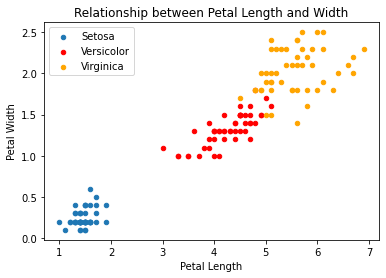

In [6]:
# scatter plot of sepal length and width data coloured by species
plt.figure(figsize=(14,8))
ax = df[df.target==0].plot.scatter(x='petal length (cm)', y='petal width (cm)', label='Setosa')
df[df.target==1].plot.scatter(x='petal length (cm)', y='petal width (cm)', color='red', label='Versicolor', ax=ax)
df[df.target==2].plot.scatter(x='petal length (cm)', y='petal width (cm)', color='orange', label='Virginica', ax=ax)
ax.set_xlabel("Petal Length")
ax.set_ylabel("Petal Width")
ax.set_title("Relationship between Petal Length and Width")
plt.show()

array([[<AxesSubplot:title={'center':'petal length (cm)'}, xlabel='[target]'>,
        <AxesSubplot:title={'center':'petal width (cm)'}, xlabel='[target]'>],
       [<AxesSubplot:title={'center':'sepal length (cm)'}, xlabel='[target]'>,
        <AxesSubplot:title={'center':'sepal width (cm)'}, xlabel='[target]'>]],
      dtype=object)

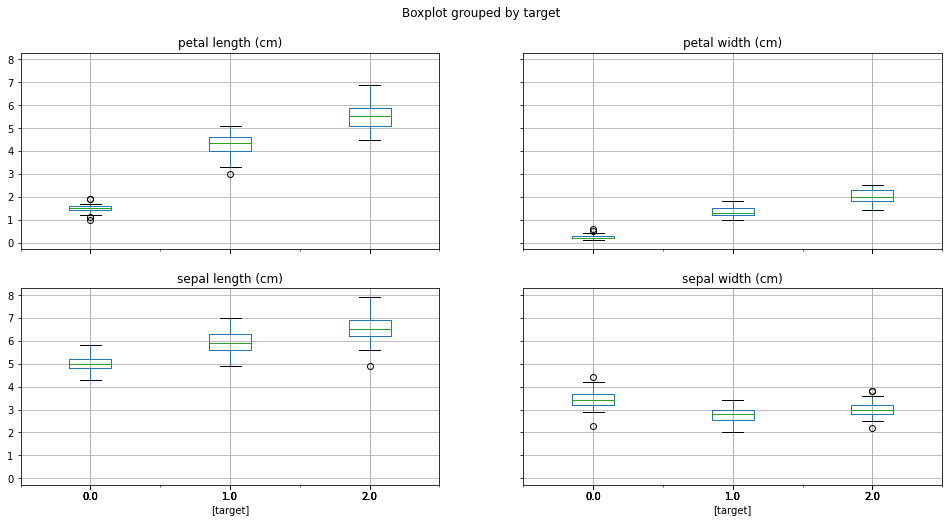

In [7]:
# boxplot by species
df.boxplot(by = 'target', figsize = (16,8))

/home/kate/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


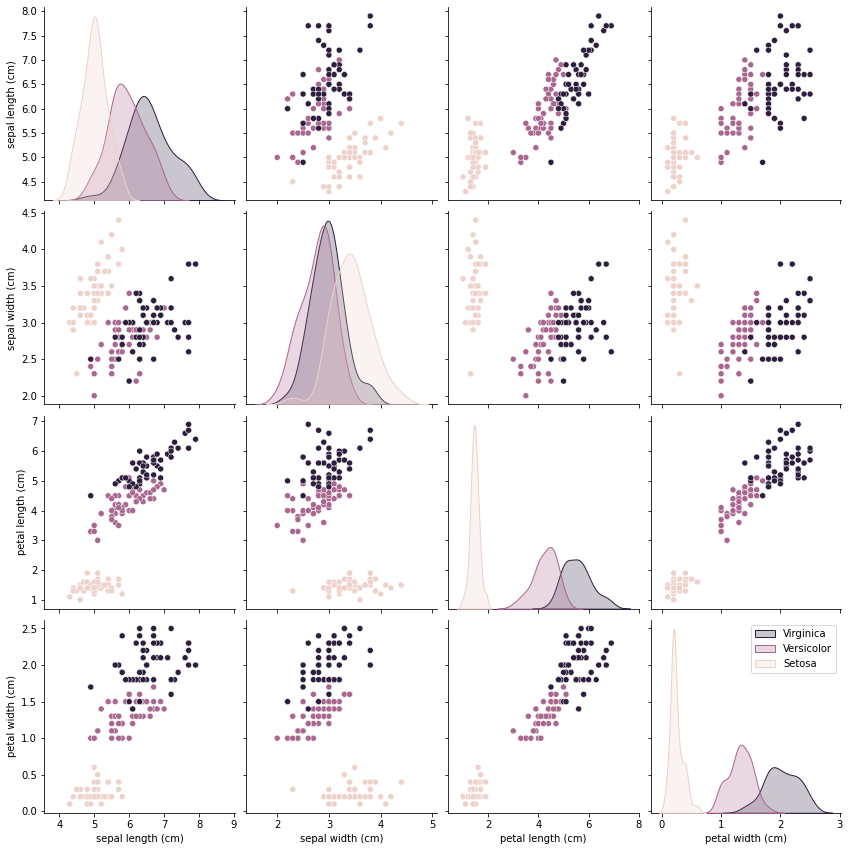

In [8]:
# pairplot - shows the bivariate relation among features
pairplot = sns.pairplot(data = df, hue = 'target', size = 3)
pairplot._legend.remove()
plt.legend(labels=['Virginica', 'Versicolor', 'Setosa'])

(array([48.,  2., 15., 37., 25., 23.]),
 array([0.1, 0.5, 0.9, 1.3, 1.7, 2.1, 2.5]),
 <BarContainer object of 6 artists>)

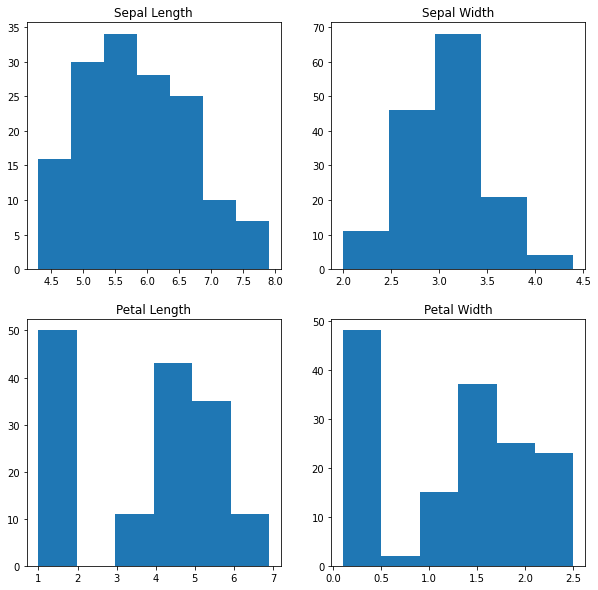

In [9]:
# plot histograms of each feature
fig, axes = plt.subplots(2, 2, figsize=(10,10))
 
axes[0,0].set_title("Sepal Length")
axes[0,0].hist(df['sepal length (cm)'], bins=7)
 
axes[0,1].set_title("Sepal Width")
axes[0,1].hist(df['sepal width (cm)'], bins=5)
 
axes[1,0].set_title("Petal Length")
axes[1,0].hist(df['petal length (cm)'], bins=6)
 
axes[1,1].set_title("Petal Width")
axes[1,1].hist(df['petal width (cm)'], bins=6)

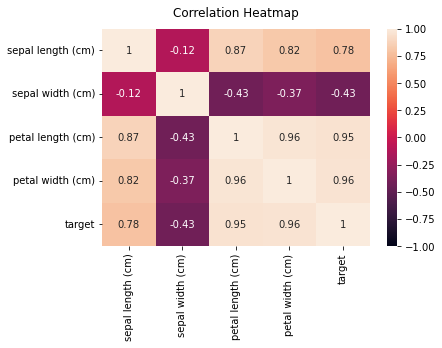

In [10]:
# heatmap of data
heatmap = sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

In [11]:
# ---CLEAN DATA---
# already dropped duplicates, check for nulls (none were found)
df.isnull().values.any()

False

In [12]:
# check for NaNs (none were found)
df.isna().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64

In [13]:
# dropping outliers by Interquartile Range
for column in df.columns[1:-1]:
    for specy in df["target"].unique():
        Specy_type = df[df["target"] == specy]
        Selected_column = Specy_type[column]
        q1 = Selected_column.quantile(0.25) # for select first quartile
        q3 = Selected_column.quantile(0.75) # for select third quartile
        iqr = q3 - q1 # this is interquartile range
        upper_limit = q3 + 1.5 * iqr
        lower_limit = q1 - 1.5 * iqr        
        outlierss = Selected_column[(Selected_column > upper_limit) | (Selected_column < lower_limit)].index # picking outliers' indeces
        print(outlierss)
        df.drop(index = outlierss, inplace=True) # dropping outliers

Int64Index([15, 41], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([117, 119, 131], dtype='int64')
Int64Index([22], dtype='int64')
Int64Index([98], dtype='int64')
Int64Index([118], dtype='int64')
Int64Index([23, 43], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


In [14]:
# ---MODELLING using XGBoost---
from sklearn.model_selection import train_test_split
import xgboost as xgb 
from sklearn.metrics import accuracy_score, confusion_matrix

In [15]:
# split data into train and test datasets
x_train , x_test , y_train , y_test = train_test_split( df.iloc[:,0:-1] , df.iloc[:,-1] , test_size=0.2 )

In [16]:
# train model
xgb_clsfr = xgb.XGBClassifier(objective="multiclass:softmax", num_class=3)
xgb_clsfr.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [17]:
# run predictions
predictions = xgb_clsfr.predict(x_test)
predictions

array([1, 2, 0, 1, 2, 1, 0, 1, 2, 0, 0, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 0,
       0, 1, 0, 2, 0, 1])

In [19]:
# check accuracy - closer to 1 is more accurate
accuracy_score(y_test, predictions)

1.0

In [20]:
# plot confusion matrix
# No false negatives or false positives observed
confusion_matrix(y_test,predictions)

array([[ 8,  0,  0],
       [ 0,  9,  0],
       [ 0,  0, 11]])